# Preview

In this example, we are going to use our toolbox to write the [PETS](https://arxiv.org/pdf/1805.12114.pdf) algorithm (Chua at al., 2018), and use it to solve a continuous version of the cartpole environment. PETS is a model-based algorithm that consists of two main components: an ensemble of probabilistic models (each a feed-forward neural network), and a planner using the [Cross-Entropy Method](https://people.smp.uq.edu.au/DirkKroese/ps/aortut.pdf) (de Boer et al., 2004). 

A basic implementation of this algorithm consists of the following sequence of steps:

1. Gather data using an exploration policy
2. Repeat:<br>
  2.1. Train the dynamics model using all available data.<br>
  2.2. Do a trajectory on the environment, choosing actions with the planner, using the dynamics model to simulate environment transitions.
  
The ensemble model is trained to predict the environment's dynamics, and the planner tries to find high-reward trajectories over the model dynamics. 

To implement this using `MBRL-Lib`, we will use an ensemble of neural networks (NNs) modelling Gaussian distributions (available in the [mbrl.models](https://luisenp.github.io/mbrl-lib/models.html#mbrl.models.GaussianMLP) module), and a trajectory optimizer agent that uses CEM (available in the [mbrl.planning](https://luisenp.github.io/mbrl-lib/planning.html#mbrl.planning.TrajectoryOptimizerAgent) module). We will also rely on several of the utilities available in the [mbrl.util](https://luisenp.github.io/mbrl-lib/util.html) module. Finally, we will wrap the dynamics model into a [gym-like environment](https://luisenp.github.io/mbrl-lib/models.html#mbrl.models.ModelEnv) over which we can plan action sequences.

In [1]:
from IPython import display
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import omegaconf
import time

import torch.nn.functional as F

import mbrl.env.cartpole_continuous as cartpole_env
import mbrl.env.reward_fns as reward_fns
import mbrl.env.termination_fns as termination_fns
import mbrl.models as models
import mbrl.planning as planning
import mbrl.util.common as common_util
import mbrl.util as util


%load_ext autoreload
%autoreload 2

mpl.rcParams.update({"font.size": 16})

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# produce a display to render image
from pyvirtualdisplay import Display
_display = Display(visible=False, size=(1400, 900))
_ = _display.start()

# Creating the environment

First we instantiate the environment and specify which reward function and termination function to use with the gym-like environment wrapper, along with some utility objects. The termination function tells the wrapper if an observation should cause an episode to end or not, and it is an input used in some algorithms, like [MBPO](https://github.com/JannerM/mbpo/blob/master/mbpo/static/halfcheetah.py). The reward function is used to compute the value of the reward given an observation, and it's used by some algorithms, like [PETS](https://github.com/kchua/handful-of-trials/blob/77fd8802cc30b7683f0227c90527b5414c0df34c/dmbrl/controllers/MPC.py#L65).

In [3]:
seed = 0
env = cartpole_env.CartPoleEnv()
env.seed(seed)
rng = np.random.default_rng(seed=0)
generator = torch.Generator(device=device)
generator.manual_seed(seed)
obs_shape = env.observation_space.shape
act_shape = env.action_space.shape

# This functions allows the model to evaluate the true rewards given an observation 
reward_fn = reward_fns.cartpole
# This function allows the model to know if an observation should make the episode end
term_fn = termination_fns.cartpole

In [4]:
# Custom reward and termination functions that works with tensors and batches
print(obs_shape)
print(act_shape)

obs = torch.randn(10, obs_shape[0])
act = torch.randn(2, act_shape[0])
print(reward_fn(act, obs).shape)
print(term_fn(act, obs).shape)

reward_fn(act, obs).float().view(-1, 1)

(4,)
(1,)
torch.Size([10, 1])
torch.Size([10, 1])


tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

# Hydra configuration

MBRL-Lib uses [Hydra](https://github.com/facebookresearch/hydra) to manage configurations. For the purpose of this example, you can think of the configuration object as a dictionary with key/value pairs--and equivalent attributes--that specify the model and algorithmic options. Our toolbox expects the configuration object to be organized as follows:

In [5]:
trial_length = 200
num_trials = 10
ensemble_size = 5

# Everything with "???" indicates an option with a missing value.
# Our utility functions will fill in these details using the 
# environment information
cfg_dict = {
    # dynamics model configuration
    "dynamics_model": {
        "_target_": "mbrl.models.GaussianMLP",
        "device": device,
        "num_layers": 3,
        "ensemble_size": ensemble_size,
        "hid_size": 200,
        "in_size": "???",
        "out_size": "???",
        "deterministic": False,
        "propagation_method": "fixed_model",
        # can also configure activation function for GaussianMLP
        "activation_fn_cfg": {
            "_target_": "torch.nn.LeakyReLU",
            "negative_slope": 0.01
        }
    },
    # options for training the dynamics model
    "algorithm": {
        "learned_rewards": False,
        "target_is_delta": True,
        "normalize": True,
    },
    # these are experiment specific options
    "overrides": {
        "trial_length": trial_length,
        "num_steps": num_trials * trial_length,
        "model_batch_size": 32,
        "validation_ratio": 0.05
    }
}
cfg = omegaconf.OmegaConf.create(cfg_dict)

<div class="alert alert-block alert-info"><b>Note: </b> This example uses a probabilistic ensemble. You can also use a fully deterministic model with class GaussianMLP by setting ensemble_size=1, and deterministic=True. </div>

# Creating a dynamics model

Given the configuration above, the following two lines of code create a wrapper for 1-D transition reward models, and a gym-like environment that wraps it, which we can use for simulating the real environment. The 1-D model wrapper takes care of creating input/output data tensors to the underlying NN model (by concatenating observations, actions and rewards appropriately), normalizing the input data to the model, and other data processing tasks (e.g., converting observation targets to deltas with respect to the input observation).

In [6]:
# Create a 1-D dynamics model for this environment
dynamics_model = common_util.create_one_dim_tr_model(cfg, obs_shape, act_shape)

# Create a gym-like environment to encapsulate the model
model_env = models.ModelEnv(env, dynamics_model, term_fn, reward_fn, generator=generator)

/home/qt21590/anaconda3/envs/tactile_gym_mbrl/lib/python3.9/site-packages/hydra/utils.py:32: UserWarning: `OmegaConf.is_none()` is deprecated, see https://github.com/omry/omegaconf/issues/547
  if OmegaConf.is_none(config):


In [7]:
print(dynamics_model.model)

GaussianMLP(
  (hidden_layers): Sequential(
    (0): Sequential(
      (0): EnsembleLinearLayer(num_members=5, in_size=5, out_size=200, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): EnsembleLinearLayer(num_members=5, in_size=200, out_size=200, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): EnsembleLinearLayer(num_members=5, in_size=200, out_size=200, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (mean_and_logvar): EnsembleLinearLayer(num_members=5, in_size=200, out_size=8, bias=True)
)


In [8]:
# print(dynamics_model.model.hidden_layers[0][0].weight.flatten().shape)
# plt.subplot(3, 1, 1)
# plt.hist(dynamics_model.model.hidden_layers[0][0].weight.flatten().detach().numpy())
# plt.tick_params(axis='x', colors='white')
# plt.tick_params(axis='y', colors='white')
# plt.subplot(3, 1, 2)
# plt.hist(dynamics_model.model.hidden_layers[1][0].weight.flatten().detach().numpy())
# plt.tick_params(axis='x', colors='white')
# plt.tick_params(axis='y', colors='white')
# plt.gcf().set_size_inches(5, 8)
# plt.subplot(3, 1, 3)
# plt.hist(dynamics_model.model.hidden_layers[1][0].bias.flatten().detach().numpy())
# plt.tick_params(axis='x', colors='white')
# plt.tick_params(axis='y', colors='white')
# plt.gcf().set_size_inches(5, 8)

# plt.show()

# Create a replay buffer

We can create a replay buffer for this environment an configuration using the following method

In [9]:
replay_buffer = common_util.create_replay_buffer(cfg, obs_shape, act_shape, rng=rng)

We can now populate the replay buffer with random trajectories of a desired length, using a single function call to `util.rollout_agent_trajectories`. Note that we pass an agent of type `planning.RandomAgent` to generate the actions; however, this method accepts any agent that is a subclass of `planning.Agent`, allowing changing exploration strategies with minimal changes to the code. 

In [10]:
common_util.rollout_agent_trajectories(
    env,
    trial_length, # initial exploration steps
    planning.RandomAgent(env),
    {}, # keyword arguments to pass to agent.act()
    replay_buffer=replay_buffer,
    trial_length=trial_length
)

print("# samples stored", replay_buffer.num_stored)

# samples stored 200


# CEM Agent

The following config object and the subsequent function call create an agent that can plan using the Cross-Entropy Method over the model environment created above. When calling `planning.create_trajectory_optim_agent_for_model`, we also specify how many particles to use when propagating model uncertainty, as well as the uncertainty propagation method, "fixed_model", which corresponds to the method TS$\infty$ in the PETS paper.

In [11]:
agent_cfg = omegaconf.OmegaConf.create({
    # this class evaluates many trajectories and picks the best one
    "_target_": "mbrl.planning.TrajectoryOptimizerAgent",
    "planning_horizon": 15,
    "replan_freq": 1,
    "verbose": False,
    "action_lb": "???",
    "action_ub": "???",
    # this is the optimizer to generate and choose a trajectory
    "optimizer_cfg": {
        "_target_": "mbrl.planning.CEMOptimizer",
        "num_iterations": 5,
        "elite_ratio": 0.1,
        "population_size": 500,
        "alpha": 0.1,
        "device": device,
        "lower_bound": "???",
        "upper_bound": "???",
        "return_mean_elites": True,
        "clipped_normal": False
    }
})

agent = planning.create_trajectory_optim_agent_for_model(
    model_env,
    agent_cfg,
    num_particles=20
)

In [12]:
# Play with evaluation sequences

# initialise action sequence
action_lb = env.action_space.low.tolist()
action_ub = env.action_space.high.tolist()
initial_solution = (((torch.tensor(action_lb) + torch.tensor(action_ub)) / 2)
            .float().to(device)
        )
initial_solution = initial_solution.repeat((agent_cfg['planning_horizon'], 1))
mu, dispersion = agent.optimizer.optimizer._init_population_params(initial_solution)
action_sequences = torch.zeros((500,) + initial_solution.shape).to(device)
action_sequences = agent.optimizer.optimizer._sample_population(mu, dispersion, action_sequences)

population_size, horizon, action_dim = action_sequences.shape
action_for_step = action_sequences[:, 0, :]
print(action_for_step.shape)
action_batch = torch.repeat_interleave(action_for_step, 20, dim=0)
print(action_batch.shape)

# intialise state
initial_state = env.reset()
tiling_shape = (20 * 500,) + tuple(
    [1] * initial_state.ndim
)
initial_obs_batch = np.tile(initial_state, tiling_shape).astype(np.float32)
model_state = model_env.reset(initial_obs_batch, return_as_np=False)
print(model_state['obs'].shape)
batch_size = initial_obs_batch.shape[0]
total_rewards = torch.zeros(batch_size, 1)
terminated = torch.zeros(batch_size, 1, dtype=bool)

total_rewards_shaped = total_rewards.reshape(-1, 20)
print(total_rewards_shaped.shape) # take the average of this to get back population rewards
print(total_rewards_shaped.mean(dim=1).shape)

torch.Size([500, 1])
torch.Size([10000, 1])
torch.Size([10000, 4])
torch.Size([500, 20])
torch.Size([500])


# Running PETS

Having a model and an agent, we can now run PETS with a simple loop and a few function calls. The first code block creates a callback to pass to the model trainer to accumulate the training losses and validation scores observed. The second block is just a utility function to update the agent's visualization.

In [13]:
train_losses = [0.0]
val_scores = [0.0]

def train_callback(_model, _total_calls, _epoch, tr_loss, val_score, _best_val):
    train_losses.append(tr_loss)
    val_scores.append(val_score.mean().item())   # this returns val score per ensemble model
    

In [14]:
def update_axes(_axs, _frame, _text, _trial, _steps_trial, _plan_time, _train_time, _all_rewards, _train_loss, _val_loss, force_update=False):
    if not force_update and (_steps_trial % 10 != 0):
        return
    _axs[0].imshow(_frame)
    _axs[0].set_xticks([])
    _axs[0].set_yticks([])
    _axs[0].tick_params(axis='x', colors='white')
    _axs[0].tick_params(axis='y', colors='white')
    _axs[1].clear()
    _axs[1].set_xlim([0, num_trials + .1])
    _axs[1].set_ylim([0, 200])
    _axs[1].set_xlabel("Trial")
    _axs[1].set_ylabel("Trial reward")
    _axs[1].xaxis.label.set_color('white')
    _axs[1].yaxis.label.set_color('white')
    _axs[1].tick_params(axis='x', colors='white')
    _axs[1].tick_params(axis='y', colors='white')
    _axs[1].plot(_all_rewards, 'bs-')
    _text.set_text("Trial {}: {} steps\nTrain Loss: {:.2f}\nVal Loss: {:.3g}\nPlan time: {:.2f} s/step\nTrain time: {:.2f} s".format(_trial + 1, _steps_trial, _train_loss, _val_loss, _plan_time, _train_time))
    display.display(plt.gcf())  
    display.clear_output(wait=True)

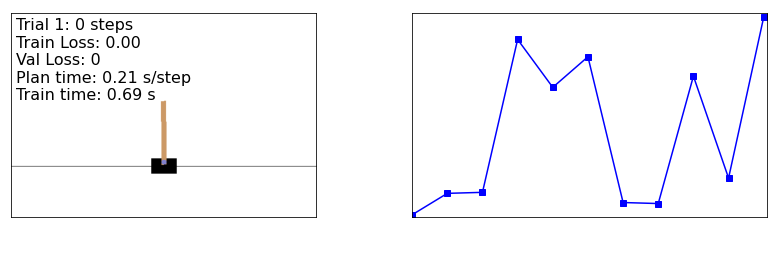

In [15]:
env.reset()
# fig = plt.figure()
# ax = fig.add_subplot()
# ax.tick_params(axis='x', colors='white')
# ax.tick_params(axis='y', colors='white')
# plt.imshow(env.render('rgb_array'))
# plt.grid(False)

# Create visualization objects
fig, axs = plt.subplots(1, 2, figsize=(14, 3.75), gridspec_kw={"width_ratios": [1, 1]})
ax_text = axs[0].text(10, 170, "")
all_rewards = np.random.randint(0, 200, 11)
plan_time = np.random.rand()
train_time = np.random.rand()
update_axes(axs,env.render(mode="rgb_array"), ax_text, 0, 0, plan_time, train_time, all_rewards, train_losses[-1], val_scores[-1], force_update=True)

Training time:  0.5487217903137207


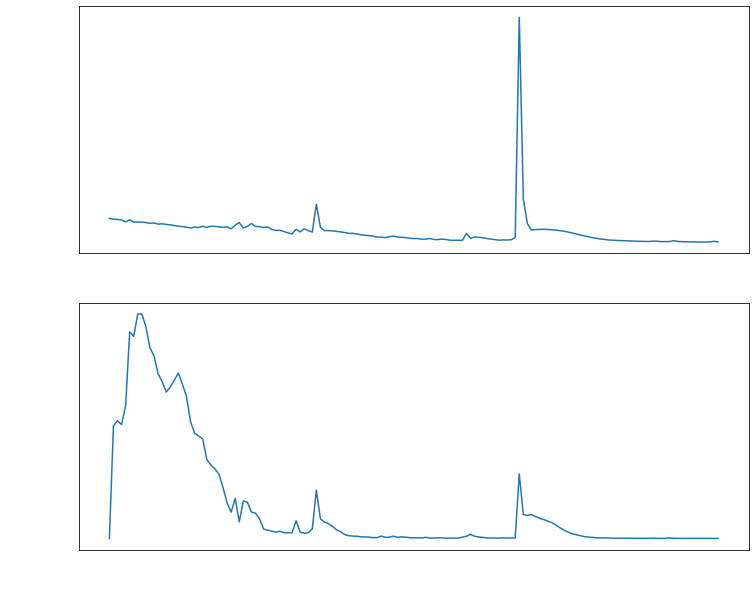

In [24]:
# Test optimisation iterations for CEM

# Train model first
model_trainer = models.ModelTrainer(dynamics_model, optim_lr=1e-3, weight_decay=5e-5)
dynamics_model.update_normalizer(replay_buffer.get_all()) 
dataset_train, dataset_val = common_util.get_basic_buffer_iterators(
    replay_buffer,
    batch_size=cfg.overrides.model_batch_size,
    val_ratio=cfg.overrides.validation_ratio,
    ensemble_size=ensemble_size,
    shuffle_each_epoch=True,
    bootstrap_permutes=False,  # build bootstrap dataset using sampling with replacement
)

start_train_time = time.time()
model_trainer.train(
    dataset_train, 
    dataset_val=dataset_val, 
    num_epochs=50, 
    patience=50, 
    callback=train_callback,
    silent=True)
train_time = time.time() - start_train_time

print("Training time: ", train_time)

fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax[0].plot(train_losses)
ax[0].set_xlabel("Total training epochs")
ax[0].set_ylabel("Training loss (avg. NLL)")
ax[0].xaxis.label.set_color('white')
ax[0].yaxis.label.set_color('white')
ax[0].tick_params(axis='x', colors='white')
ax[0].tick_params(axis='y', colors='white')
ax[1].plot(val_scores)
ax[1].set_xlabel("Total training epochs")
ax[1].set_ylabel("Validation score (avg. MSE)")
ax[1].xaxis.label.set_color('white')
ax[1].yaxis.label.set_color('white')
ax[1].tick_params(axis='x', colors='white')
ax[1].tick_params(axis='y', colors='white')
plt.show()

In [17]:
data = replay_buffer.get_all()
print(200 - np.size(data.dones) + np.count_nonzero(data.dones))

7


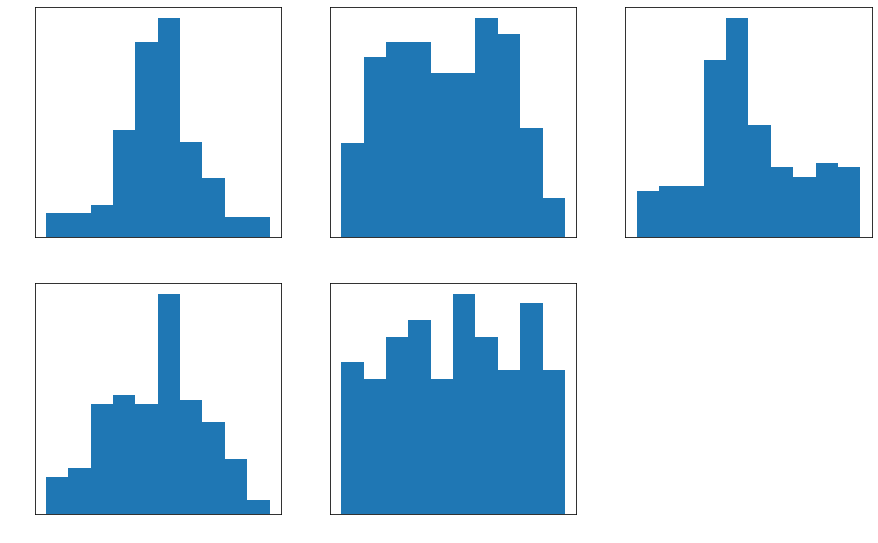

In [18]:
# Plot histogram for all the 5 features for input obs
batch = replay_buffer.get_all()
obs = batch.obs
act = batch.act
model_in = np.concatenate([obs, act], axis=obs.ndim - 1)

for i in range(1,6):
    plt.subplot(10, 3, i)
    plt.hist(model_in[:, i-1])
    plt.tick_params(axis='x', colors='white')
    plt.tick_params(axis='y', colors='white')

plt.gcf().set_size_inches(15, 50)
plt.show()

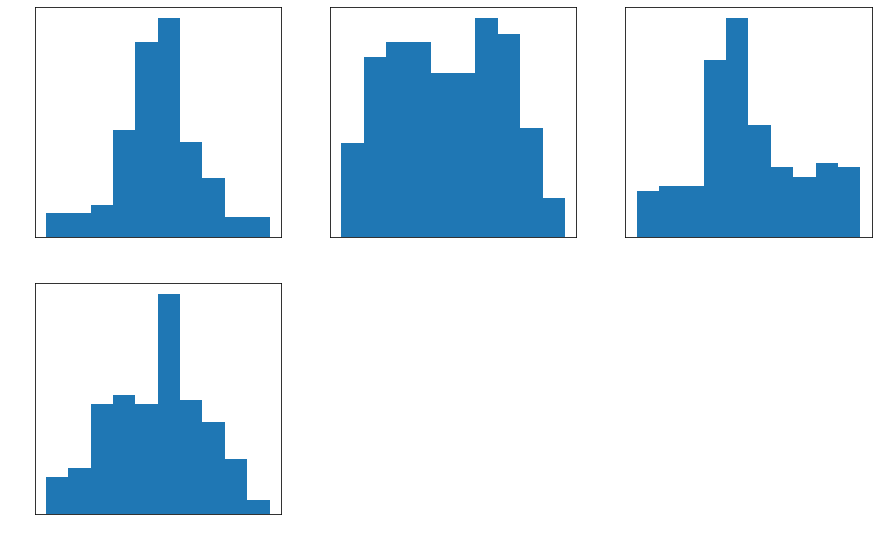

In [19]:
# Plot histogram for all the 4 features for target obs
batch = replay_buffer.get_all()
obs = batch.obs
act = batch.act
model_in = np.concatenate([obs, act], axis=obs.ndim - 1)

for i in range(1,obs_shape[0]+1):
    plt.subplot(10, 3, i)
    plt.hist(model_in[:, i-1])
    plt.tick_params(axis='x', colors='white')
    plt.tick_params(axis='y', colors='white')

plt.gcf().set_size_inches(15, 50)
plt.show()

In [20]:
# The mean and variance of the replay buffer data
print(dynamics_model.input_normalizer.mean)
print(dynamics_model.input_normalizer.std)

tensor([[-0.0014,  0.0726, -0.0006, -0.0594,  0.0309]])
tensor([[0.0688, 0.3583, 0.0978, 0.5358, 0.5548]])


In [21]:
# Get batch of data for val data
dataset_val.__iter__()
batch = dataset_val.__next__()

# Process batch function
obs, action, next_obs, reward, _ = batch.astuple()
model_in = model_trainer.model._get_model_input(obs, action)
target_obs = next_obs - obs
target_obs = torch.from_numpy(target_obs)

pred_mean, pred_logvar = dynamics_model.model._default_forward(model_in, use_propagation=False)
target_obs = target_obs.repeat((5, 1, 1))

print("Pred mean ", pred_mean[0,0])
print("Target obs", target_obs[0,0])
print("Pred logvar ", pred_logvar[0,0])
# print(obs[0,0])
# print(next_obs[0,0])

l2 = F.mse_loss(pred_mean, target_obs, reduction="none")
inv_var = (-pred_logvar).exp()
first_term_loss = l2*inv_var
second_term_loss = pred_logvar

# print(l2[0][0])
# print(inv_var[0][0])
# print(first_term_loss[0][0])
# print(second_term_loss[0][0])

# nll = util.math.gaussian_nll(pred_mean, pred_logvar, target_obs, reduce=False)
# print(nll[0,0])

print("mse ", l2.mean((1, 2)).sum())
print("inv_var ", inv_var.mean((1, 2)).sum())
print("loss term 1 ", first_term_loss.mean((1, 2)).sum())
print("loss term 2 ", second_term_loss.mean((1, 2)).sum())

nll = (util.math.gaussian_nll(pred_mean, pred_logvar, target_obs, reduce=False)
.mean((1, 2))
.sum())
print("nll ", nll)

print(0.01 * (dynamics_model.model.max_logvar.sum() - dynamics_model.model.min_logvar.sum()))
print(dynamics_model.model.max_logvar.sum())

Pred mean  tensor([-0.0187, -0.0248, -0.0259,  0.0262], grad_fn=<SelectBackward0>)
Target obs tensor([-0.0104, -0.0235,  0.0147,  0.0452])
Pred logvar  tensor([-6.9415, -6.7280, -5.6843, -5.4325], grad_fn=<SelectBackward0>)
mse  tensor(0.0057, grad_fn=<SumBackward0>)
inv_var  tensor(2063.9714, grad_fn=<SumBackward0>)
loss term 1  tensor(1.5571, grad_fn=<SumBackward0>)
loss term 2  tensor(-21.7022, grad_fn=<SumBackward0>)
nll  tensor(-20.1451, grad_fn=<SumBackward0>)
tensor(0.4200)
tensor(2.)


In [18]:
# ----------------- Test model output for planning horizon -------------

planning_horizon = agent_cfg['planning_horizon']

action_lb = env.action_space.low.tolist()
action_ub = env.action_space.high.tolist()
initial_solution = (((torch.tensor(action_lb) + torch.tensor(action_ub)) / 2)
            .float()
        )
initial_solution = initial_solution.repeat((planning_horizon, 1))

mu, dispersion = agent.optimizer.optimizer._init_population_params(initial_solution)
action_sequences = torch.zeros((500,) + initial_solution.shape)
action_sequences = agent.optimizer.optimizer._sample_population(mu, dispersion, action_sequences)

# Initialise states
initial_state = env.reset()
tiling_shape = (20 * 500,) + tuple(
    [1] * initial_state.ndim
)
initial_obs_batch = np.tile(initial_state, tiling_shape).astype(np.float32)
model_state = model_env.reset(initial_obs_batch, return_as_np=False)
batch_size = initial_obs_batch.shape[0]
total_rewards = torch.zeros(batch_size, 1)
terminated = torch.zeros(batch_size, 1, dtype=bool)

for time_step in range(planning_horizon):
    print(torch.mean(model_state["obs"], 0))
    action_for_step = action_sequences[:, time_step, :]
    action_batch = torch.repeat_interleave(
        action_for_step, 20, dim=0
    )
    _, rewards, dones, model_state = model_env.step(
        action_batch, model_state, sample=True
    )
    rewards[terminated] = 0
    terminated |= dones
    total_rewards += rewards

tensor([ 0.0471, -0.0241,  0.0419,  0.0367])
tensor([ 0.0288, -0.0464,  0.0406,  0.0536])
tensor([ 0.0125, -0.0640,  0.0396,  0.0691])
tensor([-0.0028, -0.0827,  0.0394,  0.0857])
tensor([-0.0201, -0.1002,  0.0396,  0.1009])
tensor([-0.0397, -0.1256,  0.0406,  0.1221])
tensor([-0.0626, -0.1466,  0.0425,  0.1343])
tensor([-0.0902, -0.1822,  0.0454,  0.1600])
tensor([-0.1237, -0.2296,  0.0493,  0.1973])
tensor([-0.1648, -0.2789,  0.0550,  0.2274])
tensor([-0.2155, -0.3411,  0.0621,  0.2638])
tensor([-0.2786, -0.4169,  0.0711,  0.3040])
tensor([-0.3570, -0.5222,  0.0827,  0.3666])
tensor([-0.4549, -0.6438,  0.0975,  0.4295])
tensor([-0.5759, -0.8041,  0.1158,  0.5173])


In [23]:
# -------- Test model one set of action sequences from buffer to see exploding -------
# states still occur
planning_horizon = 40

# Get action sequence from buffer
data = replay_buffer.get_all()
action_sequences = data.act[0:planning_horizon,:]
action_sequences = np.tile(action_sequences, (5,1,1)).astype(np.float32)
action_sequences = torch.from_numpy(action_sequences)
print(action_sequences.shape)

# Random action sequence between and upper and lower bound
# action_sequences = np.array([env.action_space.sample() for _ in range(planning_horizon)])
# action_sequences = np.tile(action_sequences, (5,1,1)).astype(np.float32)
# action_sequences = torch.from_numpy(action_sequences)
# print(action_sequences.shape)


# Get action sequence from bounds
# action_lb = env.action_space.low.tolist()
# action_ub = env.action_space.high.tolist()
# initial_solution = (((torch.tensor(action_lb) + torch.tensor(action_ub)) / 2)
#             .float()
#         )
# initial_solution = initial_solution.repeat((planning_horizon, 1))

# mu, dispersion = agent.optimizer.optimizer._init_population_params(initial_solution)
# action_sequences = torch.zeros((5,) + initial_solution.shape)
# action_sequences = agent.optimizer.optimizer._sample_population(mu, dispersion, action_sequences)


# Initialise state and create model input
initial_state = data.obs[0]
print(initial_state.shape)
initial_obs_batch = np.tile(initial_state, (5,1)).astype(np.float32)
print(initial_obs_batch.shape)
model_state = model_env.reset(initial_obs_batch, return_as_np=False)
# print(model_state)

batch_size = initial_obs_batch.shape[0]
total_rewards = torch.zeros(batch_size, 1)
terminated = torch.zeros(batch_size, 1, dtype=bool)


for time_step in range(planning_horizon):
    # print(model_state["obs"])
    # print(model_state["obs"].shape)
    # print(torch.mean(model_state["obs"], 0))
    action_for_step = action_sequences[:, time_step, :]
    action_batch = action_for_step

    # -------------- Use model.forward()-------------------------
    with torch.no_grad():
        obs = model_state["obs"]
        model_in = model_env.dynamics_model._get_model_input(model_state["obs"], action_batch)
        means, logvars = model_env.dynamics_model.model.forward(
            model_in, rng=model_env._rng, propagation_indices=model_state["propagation_indices"]
        )
        variances = logvars.exp()
        stds = torch.sqrt(variances)
        next_observs = torch.normal(means, stds, generator=model_env._rng)
        next_observs += obs
        model_state["obs"] = next_observs
        # print("predicted log var", logvars[0])
        print("predicted obs", next_observs[0])

torch.Size([5, 40, 1])
(4,)
(5, 4)
predicted obs tensor([-0.3602,  0.2196, -0.1956, -0.4332])
predicted obs tensor([-0.5068, -0.0324, -0.0587, -0.4744])
predicted obs tensor([-0.5519, -0.1159,  0.0951, -0.5063])
predicted obs tensor([-0.5179, -0.0844,  0.2632, -0.6061])
predicted obs tensor([-0.4514,  0.0236,  0.4169, -0.6584])
predicted obs tensor([-0.4330, -0.0832,  0.4550, -0.3076])
predicted obs tensor([-0.3887,  0.0903,  0.5407, -0.2283])
predicted obs tensor([-0.3772,  0.0736,  0.5080,  0.2041])
predicted obs tensor([-0.4037,  0.0164,  0.4673,  0.6423])
predicted obs tensor([-0.4509,  0.1203,  0.4842,  0.9069])
predicted obs tensor([-0.4319,  0.3013,  0.5232,  1.1473])
predicted obs tensor([-0.5337,  0.2929,  0.4812,  1.6522])
predicted obs tensor([-0.4491,  0.5248,  0.5178,  1.8362])
predicted obs tensor([-0.5784,  0.5262,  0.4659,  2.4052])
predicted obs tensor([-0.5722,  0.7016,  0.4737,  2.7513])
predicted obs tensor([-0.6026,  0.9305,  0.4938,  3.0712])
predicted obs tensor(

In [31]:
obs = env.reset()
agent.reset()
def trajectory_eval_fn(action_sequences):
    return model_env.evaluate_action_sequences(action_sequences, obs, 20)

# Create initial solutions from bounds
action_lb = env.action_space.low.tolist()
action_ub = env.action_space.high.tolist()
initial_solution = (
            ((torch.tensor(action_lb) + torch.tensor(action_ub)) / 2)
            .float().to(device)
        )
initial_solution = initial_solution.repeat((agent_cfg['planning_horizon'], 1))

# Create random initial solutions
# initial_solution = torch.from_numpy(np.array([env.action_space.sample() for _ in range(15)])).float()

def cem_callback(population, values, i):
    best_values, elite_idx = values.topk(1)
    print("Iteration {}, best value {}".format(i, best_values))

agent.optimizer.optimizer.num_iterations  = 10
# agent.optimizer.optimizer.elite_ratio =
# agent.optimizer.optimizer.population_size = 

# Optimise
agent.optimizer.optimizer.optimize(
            trajectory_eval_fn,
            x0=initial_solution,
            callback=cem_callback,
        )

Iteration 0, best value tensor([15.], device='cuda:0')
Iteration 1, best value tensor([15.], device='cuda:0')
Iteration 2, best value tensor([15.], device='cuda:0')
Iteration 3, best value tensor([15.], device='cuda:0')
Iteration 4, best value tensor([15.], device='cuda:0')
Iteration 5, best value tensor([15.], device='cuda:0')
Iteration 6, best value tensor([15.], device='cuda:0')
Iteration 7, best value tensor([15.], device='cuda:0')
Iteration 8, best value tensor([15.], device='cuda:0')
Iteration 9, best value tensor([15.], device='cuda:0')


tensor([[-1.5201e-01],
        [ 4.0280e-02],
        [ 1.7254e-02],
        [-4.3761e-02],
        [ 2.0900e-01],
        [ 1.2195e-01],
        [-8.2151e-02],
        [ 2.4277e-01],
        [-1.8102e-02],
        [-2.3629e-01],
        [-7.7069e-02],
        [ 1.5561e-04],
        [ 8.0745e-02],
        [-2.9883e-02],
        [-8.3914e-02]], device='cuda:0')

In [25]:
# Create a 1-D dynamics model for this environment
dynamics_model = common_util.create_one_dim_tr_model(cfg, obs_shape, act_shape)

# Create a gym-like environment to encapsulate the model
model_env = models.ModelEnv(env, dynamics_model, termination_fn=None, reward_fn=None, generator=generator)

replay_buffer = common_util.create_replay_buffer(cfg, obs_shape, act_shape, rng=rng)
common_util.rollout_agent_trajectories(
    env,
    trial_length, # initial exploration steps
    planning.RandomAgent(env),
    {}, # keyword arguments to pass to agent.act()
    replay_buffer=replay_buffer,
    trial_length=trial_length
)

data = replay_buffer.get_all()
print(np.mean(data.obs,0))
print(np.mean(data.rewards))
print(np.mean(data.act, 0))
print(np.mean(data.next_obs, 0))

[ 0.01254802  0.04482949 -0.00325071 -0.0596611 ]
1.0
[0.04864787]
[ 0.01344461  0.05435288 -0.00444393 -0.07481454]


/home/qt21590/anaconda3/envs/tactile_gym_mbrl/lib/python3.9/site-packages/hydra/utils.py:32: UserWarning: `OmegaConf.is_none()` is deprecated, see https://github.com/omry/omegaconf/issues/547
  if OmegaConf.is_none(config):


The following lines implement the PETS algorithm. First, we create a model trainer and pass some hyperparameters for the optimizer (Adam), along with references to the model instance to use. Then we start a loop where we execute actions of ``agent`` in the environment and train the model at the beginning of the episode (by calling ``model_trainer.train()``. At every step in the loop, we execute an agent action in the environment and populate the replay buffer by calling ``util.step_env_and_add_to_buffer()``. Importantly, at the beginning of each episode we also call ``agent.reset()`` to clear any episode dependent cache; in the case of a ``TrajectoryOptimizerAgent``, this means clearing the previous action sequence found, which is shifted at every call to obtain an initial solution for the optimizer. 

The rest of the code is mostly bookkeeping to keep track of the total reward observed during each episode, and to make sure episodes terminate after some desired length. After running this code, you should see the agent reaching the maximum reward of 200 after a few episodes.

KeyboardInterrupt: 

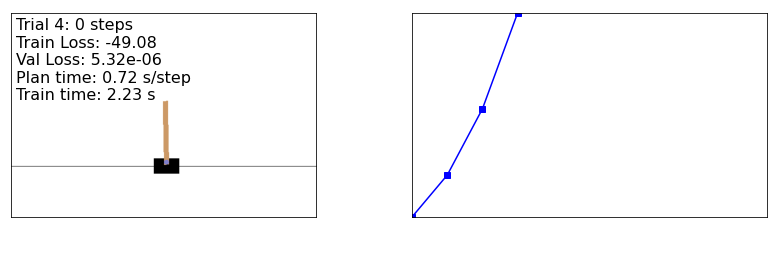

In [16]:
# Create a trainer for the model
model_trainer = models.ModelTrainer(dynamics_model, optim_lr=1e-3, weight_decay=5e-5)

# Create visualization objects
fig, axs = plt.subplots(1, 2, figsize=(14, 3.75), gridspec_kw={"width_ratios": [1, 1]})
ax_text = axs[0].text(10, 170, "")
    
# Main PETS loop
all_rewards = [0]
plan_time = 0.0
train_time = 0.0
for trial in range(num_trials):
    obs = env.reset()    
    agent.reset()
    
    done = False
    total_reward = 0.0
    steps_trial = 0
    update_axes(axs, env.render(mode="rgb_array"), ax_text, trial, steps_trial, train_time, plan_time, all_rewards, train_losses[-1], val_scores[-1])
    while not done:
        # --------------- Model Training -----------------
        if steps_trial == 0:
            dynamics_model.update_normalizer(replay_buffer.get_all())  # update normalizer stats
            
            dataset_train, dataset_val = common_util.get_basic_buffer_iterators(
                replay_buffer,
                batch_size=cfg.overrides.model_batch_size,
                val_ratio=cfg.overrides.validation_ratio,
                ensemble_size=ensemble_size,
                shuffle_each_epoch=True,
                bootstrap_permutes=False,  # build bootstrap dataset using sampling with replacement
            )
            
            start_train_time = time.time()
            model_trainer.train(
                dataset_train, 
                dataset_val=dataset_val, 
                num_epochs=50, 
                patience=50, 
                callback=train_callback,
                silent=True)
            train_time = time.time() - start_train_time

        # --- Doing env step using the agent and adding to model dataset ---
        start_plan_time = time.time()
        next_obs, reward, done, _ = common_util.step_env_and_add_to_buffer(
            env, obs, agent, {}, replay_buffer)
        plan_time = time.time() - start_plan_time

        update_axes(
            axs, env.render(mode="rgb_array"), ax_text, trial, steps_trial, plan_time, train_time, all_rewards, train_losses[-1], val_scores[-1])
        
        obs = next_obs
        total_reward += reward
        steps_trial += 1
        
        if steps_trial == trial_length:
            break
    
    all_rewards.append(total_reward)

update_axes(axs, env.render(mode="rgb_array"), ax_text, trial, steps_trial, plan_time, train_time, all_rewards, train_losses[-1], val_scores[-1], force_update=True)

Finally, below we check the results of the trainer callback, which show the training loss and validation score across all calls to ``model_trainer.train()``.

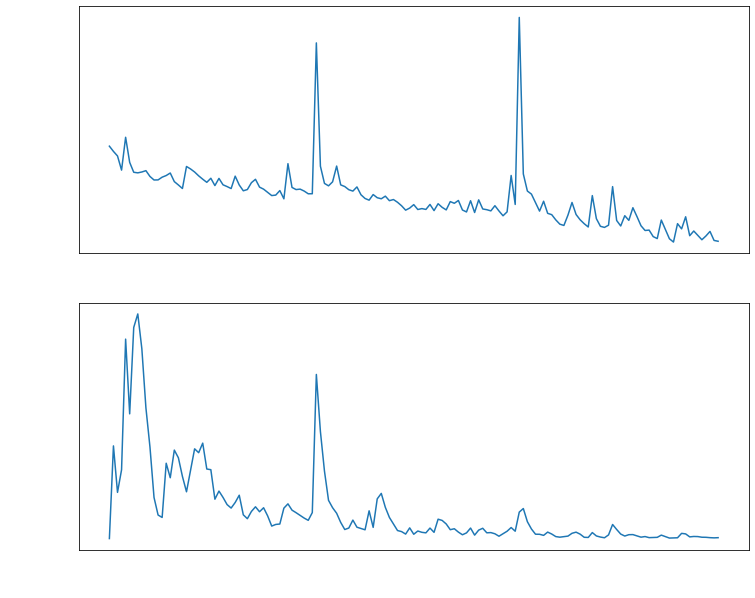

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax[0].plot(train_losses)
ax[0].set_xlabel("Total training epochs")
ax[0].set_ylabel("Training loss (avg. NLL)")
ax[0].xaxis.label.set_color('white')
ax[0].yaxis.label.set_color('white')
ax[0].tick_params(axis='x', colors='white')
ax[0].tick_params(axis='y', colors='white')
ax[1].plot(val_scores)
ax[1].set_xlabel("Total training epochs")
ax[1].set_ylabel("Validation score (avg. MSE)")
ax[1].xaxis.label.set_color('white')
ax[1].yaxis.label.set_color('white')
ax[1].tick_params(axis='x', colors='white')
ax[1].tick_params(axis='y', colors='white')
plt.show()

# Where to learn more about MBRL?

To learn about the other features of the library, please check out our [documentation](https://facebookresearch.github.io/mbrl-lib/). Also take a look at our provided implementations of [PETS](https://github.com/facebookresearch/mbrl-lib/blob/main/mbrl/algorithms/pets.py), [MBPO](https://github.com/facebookresearch/mbrl-lib/blob/main/mbrl/algorithms/mbpo.py), and [PlaNet](https://github.com/facebookresearch/mbrl-lib/blob/main/mbrl/algorithms/planet.py), and their configuration [files](https://github.com/facebookresearch/mbrl-lib/tree/main/mbrl/examples/conf).